总的来说呢，这个方法推导起来一堆东西，但是代码的实现却比较简单。对推倒原理感兴趣的可以Google一下。

# 这篇还是一样，分为暴力纯手写LDA，和sklearn的LDA

说到LDA，首先会想起PCA。两个各自的特性如下：
- PCA的目标是将一开始高维的数据降维，并尽可能保留重要信息。然后保留类内差异最大的特征（维度）（方差最大）。
- LDA的目标是通过保留包含跨类最佳分离特征值的组件来区分低维空间中的不同类。

直观来说，就是：

![](PCA_LDA.png)

对于满足LDA模型，数据需要做到：
- 删除异常值（异常值会使均值和方差的计算受到影响，从而影响LDA的计算）
- 数据需标准化
- 对每个输入特征进行单变量分析，如果它们不表现出高斯分布，则将其转换为高斯分布（指数分布的对数和根）。

LDA需要满足以下假设：
- 数据集中的每个特征（变量、维度或属性）都是高斯分布。换句话说，数据集中的每个特征都形状像钟形曲线。
- 每个特征都有相同的方差，每个特征的值围绕平均值变化，平均数量相同。
- 假设每个特征都是随机抽样的。
- 独立特征缺乏多共线性。独立特征与预测能力之间相关性的增加会降低

LDA的算法流程：
1. 计算每一个dependent variable的均值。
2. 计算类内散度矩阵和类间散度矩阵。
3. 计算SW（类内散射矩阵）和SB（类间散射矩阵）的特征值和特征向量。
4. 按降序对特征值进行排序，然后选择top k.
5. 创建一个新的矩阵包含对应到k个特征值的特征向量。
6. 通过数据和矩阵的点积来obtain new feature。

## 手写LDA

In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier #用作最终的分类
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

先简单了解下数据

In [2]:
winedataset = load_wine()
feature = pd.DataFrame(winedataset.data, columns=winedataset.feature_names)
target = pd.Categorical.from_codes(winedataset.target,winedataset.target_names)

In [3]:
feature.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [4]:
feature.shape #178行，13个变量

(178, 13)

In [5]:
feature.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

都是浮点数且没有missing value

In [6]:
target

['class_0', 'class_0', 'class_0', 'class_0', 'class_0', ..., 'class_2', 'class_2', 'class_2', 'class_2', 'class_2']
Length: 178
Categories (3, object): ['class_0', 'class_1', 'class_2']

解释变量是3分类

然后，我们将“x”和“y” merge一下，创建个新的dataframe。

In [7]:
wine = feature.join(pd.Series(target, name='class'))

In [8]:
wine[:10]

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0,class_0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0,class_0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0,class_0
8,14.83,1.64,2.17,14.0,97.0,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0,class_0
9,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0,class_0


然后，计算下每个class对应的各个变量的均值

In [9]:
between_class_feature_means = pd.DataFrame(columns=winedataset.target_names)
for i, rows in wine.groupby('class'):
    between_class_feature_means[i] = rows.mean()
between_class_feature_means

,class_0,class_1,class_2
alcohol,13.744746,12.278732,13.153750
malic_acid,2.010678,1.932676,3.333750
ash,2.455593,2.244789,2.437083
alcalinity_of_ash,17.037288,20.238028,21.416667
magnesium,106.338983,94.549296,99.312500
total_phenols,2.840169,2.258873,1.678750
flavanoids,2.982373,2.080845,0.781458
nonflavanoid_phenols,0.290000,0.363662,0.447500
proanthocyanins,1.899322,1.630282,1.153542
color_intensity,5.528305,3.086620,7.396250


创建一个within class scatter matrix

In [10]:
within_class_scatter_matrix = np.zeros((13,13))
for i, rows in wine.groupby('class'):
    rows = rows.drop(['class'],axis=1)
    
    s = np.zeros((13,13))
for index, row in rows.iterrows():
    x,mc = row.values.reshape(13,1), between_class_feature_means[i].values.reshape(13,1)
    
    s += (x - mc).dot((x - mc).T)
    
within_class_scatter_matrix += s

In [11]:
feature_means = wine.mean()
between_class_scatter_matrix = np.zeros((13,13))
for i in between_class_feature_means:
    n = len(wine.loc[wine['class'] == i].index)
    
    mc,m = between_class_feature_means[i].values.reshape(13,1),feature_means.values.reshape(13,1)
    
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)
between_class_scatter_matrix

array([[ 7.07948499e+01,  1.37229257e+01,  1.06684933e+01,
        -1.31860426e+02,  5.52620156e+02,  2.12568615e+01,
         3.00293312e+01, -2.61778351e+00,  8.30762344e+00,
         1.38875865e+02, -2.49334780e+00,  8.25295347e+00,
         2.69868967e+04],
       [ 1.37229257e+01,  6.55780370e+01,  5.15564454e+00,
         1.17928430e+02,  1.50619799e+00, -3.89429093e+01,
        -7.95309567e+01,  5.42915083e+00, -2.79935518e+01,
         1.59408872e+02, -1.79954555e+01, -5.99058382e+01,
        -6.17091332e+03],
       [ 1.06684933e+01,  5.15564454e+00,  1.75922271e+00,
        -1.28292335e+01,  7.80946503e+01,  1.09001750e+00,
         3.36713399e-01, -1.03155491e-01, -2.00866484e-01,
         2.74298320e+01, -1.23513355e+00, -1.77465829e+00,
         3.50726571e+03],
       [-1.31860426e+02,  1.17928430e+02, -1.28292335e+01,
         5.72833493e+02, -1.27015372e+03, -1.37801068e+02,
        -2.50581989e+02,  1.84145559e+01, -8.29870886e+01,
         4.34834234e+01, -3.52934937e

整出了这个类内和类间的之后，可以算线性判别值了

$ S^{-1}_{W}S_{B} $

In [12]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))

特征值最高的特征向量携带数据分布的信息最多。现在我们可以排个序并转化为半分比看看（更直观些）

In [13]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse= True)

print('每个特征值的解释向量：')
for i , pair in enumerate(pairs):
    print('eigenvector{}:{}'.format(i, (pair[0]/sum(eigen_values)).real))

每个特征值的解释向量：
eigenvector0:0.834825679938727
eigenvector1:0.1651743200612729
eigenvector2:5.002238296907953e-17
eigenvector3:3.908055287088648e-17
eigenvector4:3.908055287088648e-17
eigenvector5:3.836117754667544e-17
eigenvector6:3.836117754667544e-17
eigenvector7:3.1970658186203857e-17
eigenvector8:2.4980049061181467e-17
eigenvector9:1.4184650575682753e-17
eigenvector10:1.4184650575682753e-17
eigenvector11:1.1414476981686563e-17
eigenvector12:6.593528550568873e-18


现在为新的特征空间定义线性方程：
$$ Y = X*W$$

其中X是一个n×d矩阵，具有n个样本和d维度，Y是一个n×k矩阵，具有n个样本和k（k<n）维度。Y由LDA componets组成。

In [14]:
# 矩阵W是前两个特征向量
W = np.hstack((pairs[0][1].reshape(13,1), pairs[1][1].reshape(13,1))).real

x_lda = np.array(feature.dot(W))

In [15]:
le = LabelEncoder() #encoder一下，将标签转成数字
y = le.fit_transform(wine['class'])

In [16]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

画图

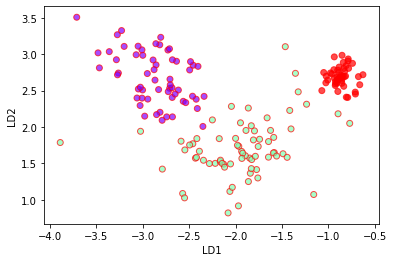

In [17]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    x_lda[:,0],
    x_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='r')

这一看就知道每个class都线性分的不错！！！！！

# Scikit-Learn的LDA

这个就简单粗暴多了，直接调就好了

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
sk_lda = LinearDiscriminantAnalysis()
x_lda = sk_lda.fit_transform(feature,target)

In [19]:
sk_lda.explained_variance_ratio_ #上面算半天，这里就一行代码的事

array([0.68747889, 0.31252111])

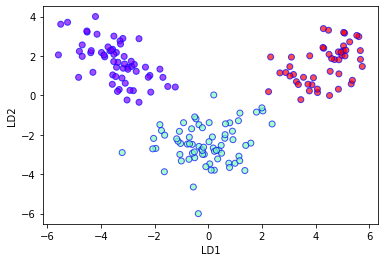

In [20]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    x_lda[:,0],
    x_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b')

两个很像，可能这个要好点

用随机森林整个分类出来看看效果。

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x_lda,y,random_state=111)

In [22]:
Model1 = RandomForestClassifier()
Model1.fit(X_train, y_train)
y_predict = Model1.predict(X_test)

In [23]:
confusion_matrix(y_test,y_predict) #观察混淆矩阵

array([[15,  0,  0],
       [ 0, 17,  0],
       [ 0,  0, 13]])

结果很完美！

接下来用原始数据，而不是LDA的试试

In [24]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(feature,y,random_state=111)

In [25]:
Model2 = RandomForestClassifier()
Model2.fit(X_train1, y_train1)
y_predict1 = Model2.predict(X_test1)

In [26]:
confusion_matrix(y_test1,y_predict1) #观察混淆矩阵

array([[15,  0,  0],
       [ 1, 15,  1],
       [ 0,  0, 13]])

## 这显示了一个Class1的错误和一个Class2的错误。这也说明，LDA对整个训练还是有价值的